In [59]:
import cv2
from skimage import io
from preprocessing import Preprocessing
from detect import LicenceDetection
import numpy as np
from scipy import ndimage
from skimage import io
from skimage.filters import  sobel_v,threshold_otsu,sobel
from commonfunctions import *
import pytesseract

# Preprocessing Testing

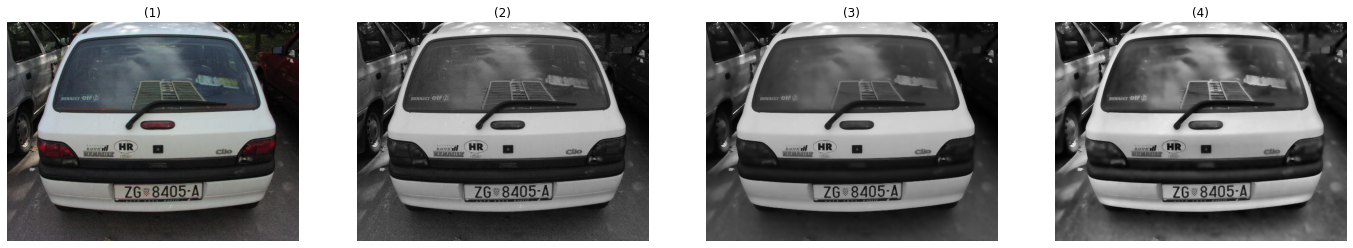

In [60]:
img = io.imread("images/sample2.jpg")
grayImage = Preprocessing.grayScale(img)
noiseFreeImage = Preprocessing.removeNoise(grayImage)
equalizedImage = Preprocessing.equilizeHistogram(noiseFreeImage)

show_images([img, grayImage, noiseFreeImage, equalizedImage])

# Verical Edge Detection Testing

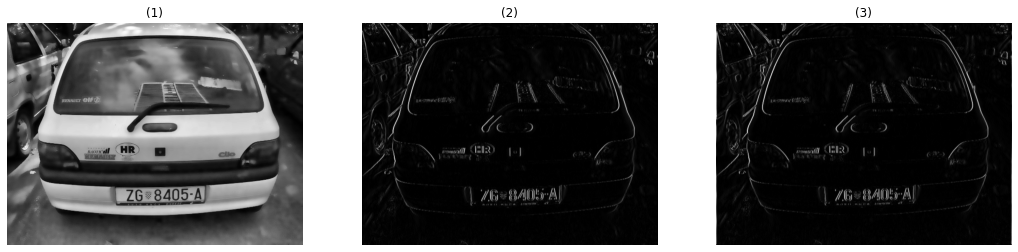

In [61]:
detectedVerticalEdgesMap = np.abs(sobel_v(equalizedImage))
sobelFilter = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
verticalEdgesDetectedImage = np.abs(convolve2d(equalizedImage, sobelFilter))

# print(equalizedImage)
# print(np.max(equalizedImage))
# equalizedImage = equalizedImage / np.max(equalizedImage)
# print(equalizedImage)
# print(np.max(equalizedImage))
# print(detectedVerticalEdgesMap)
# print(np.max(detectedVerticalEdgesMap))
# print(verticalEdgesDetectedImage)
# print(np.max(verticalEdgesDetectedImage))
show_images([equalizedImage, detectedVerticalEdgesMap, verticalEdgesDetectedImage])

# Weighted Edges Map Testing

In [62]:
print(np.mean(detectedVerticalEdgesMap))
print(np.mean(detectedVerticalEdgesMap.reshape(-1)))
weightedEdges = LicenceDetection.getWeightedEdges(detectedVerticalEdgesMap)

0.02093117468341503
0.02093117468341503


# Initial ROI Region Testing

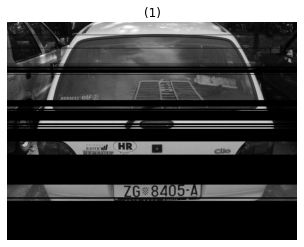

[[263, 291], [358, 393]]
0 , Roi Start =  0
0 , Roi Start =  0 , Roi End =  0
1 , Roi Start =  0 , Roi End =  0
2 , Roi Start =  0 , Roi End =  0
3 , Roi Start =  0 , Roi End =  0
4 , Roi Start =  0 , Roi End =  0
5 , Roi Start =  0 , Roi End =  0
6 , Roi Start =  0 , Roi End =  0
7 , Roi Start =  0 , Roi End =  0
8 , Roi Start =  0 , Roi End =  0
9 , Roi Start =  0 , Roi End =  0
10 , Roi Start =  0 , Roi End =  0
11 , Roi Start =  0 , Roi End =  0
12 , Roi Start =  0 , Roi End =  0
13 , Roi Start =  0 , Roi End =  0
14 , Roi Start =  0 , Roi End =  0
15 , Roi Start =  0 , Roi End =  0
16 , Roi Start =  0 , Roi End =  0
17 , Roi Start =  0 , Roi End =  0
18 , Roi Start =  0 , Roi End =  0
19 , Roi Start =  0 , Roi End =  0
20 , Roi Start =  0 , Roi End =  0
21 , Roi Start =  0 , Roi End =  0
22 , Roi Start =  0 , Roi End =  0
23 , Roi Start =  0 , Roi End =  0
24 , Roi Start =  0 , Roi End =  0
25 , Roi Start =  0 , Roi End =  0
26 , Roi Start =  0 , Roi End =  0
27 , Roi Start =  0 ,

In [63]:
rowVariance = np.var(weightedEdges, axis = 1)
# print(rowVariance)
# Get the threshold
threshVarMax = max(rowVariance) / 3
roiImage = np.zeros(weightedEdges.shape)
# print(roiImage, "\n")
roiImage[rowVariance > threshVarMax, :] = grayImage[rowVariance > threshVarMax, :]
# print(roiImage)
roi = LicenceDetection.initialRoiRegion(weightedEdges, grayImage)
show_images([roiImage])
print(roi)
roiSum = np.sum(roiImage, axis = 1)
roiStart = 0
roiEnd = 0
roiRegions = []
# print(roiSum)
inRegion = False
for i in range(len(roiSum)):
    if roiSum[i] != 0 and inRegion == False:
        if len(roiRegions) != 0 and i - roiRegions[-1][1] < 10:
            print(roiRegions, i, roiRegions[-1][1])
            roiStart, _ = roiRegions.pop()
            print(roiRegions)
        else:
            roiStart = i
        inRegion = True
        print(i, ", Roi Start = ", roiStart)
    if roiSum[i] == 0 and inRegion == True:
        roiEnd = i - 1
        inRegion = False
        print(i, ", Roi End = ", roiEnd)
        
        if roiEnd - roiStart > 15:
            print(roiRegions)
            roiRegions.append([roiStart, roiEnd])
            print(roiRegions)
    print(i, ", Roi Start = ", roiStart, ", Roi End = ", roiEnd)

    
print(roiRegions)

# Best Region Testing

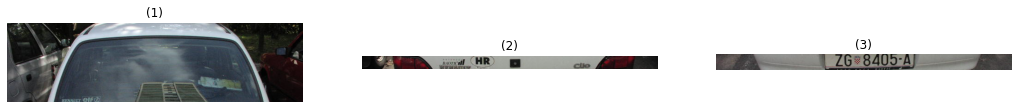

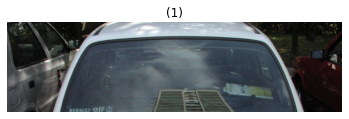

In [64]:
extractedRegionImages = []
for i in range(len(roiRegions)):
    # Get the ROI as a 2D colored image (with 3 channels)
    regionImage = img[roiRegions[i][0] : roiRegions[i][1], :]
    gray = np.float32(regionImage)
    extractedRegionImages.append(regionImage)

show_images(extractedRegionImages)
bestRegion = 0
bestWeight = 0
for i in range(len(roiRegions)):
    regionImage = weightedEdges[roiRegions[i][0] : roiRegions[i][1], :]
    regionWeight = 0
    for k in range(regionImage.shape[0] - 1, -1, -1):
        prevEdge = 0
        for j in range(20, regionImage.shape[1] - 20):
            if regionImage[k][j] != 0:
                if prevEdge == 0:
                    regionWeight += 1
                else:
                    dist = np.abs(prevEdge - j) 
                    regionWeight += 1 / np.exp(dist)
                    # print(dist, regionWeight)
                prevEdge = j
    
    if bestWeight < regionWeight:
        bestWeight = regionWeight
        bestRegion = i
show_images([img[roiRegions[bestRegion][0] : roiRegions[bestRegion][1], :]])

# Note
After multiple tests, the proposed algorithm can fail to pick the region if the image is captured from the front; an image of the rear of the car is better.

Due to shabaka :D

[[ 90  37]
 [102 245]] [[546  10]
 [558 218]]
[90 37] [546  10] 

[[233 359]
 [235 400]] [[427 350]
 [429 390]]
[233 359] [427 350] 

[[ 92 385]
 [ 92 419]] [[564 378]
 [564 412]]
[ 92 385] [564 378] 

[[ 69 355]
 [ 72 333]] [[225 374]
 [228 353]]
[ 72 333] [228 353] 

[[429 350]
 [433 374]] [[584 326]
 [588 350]]
[429 350] [584 326] 



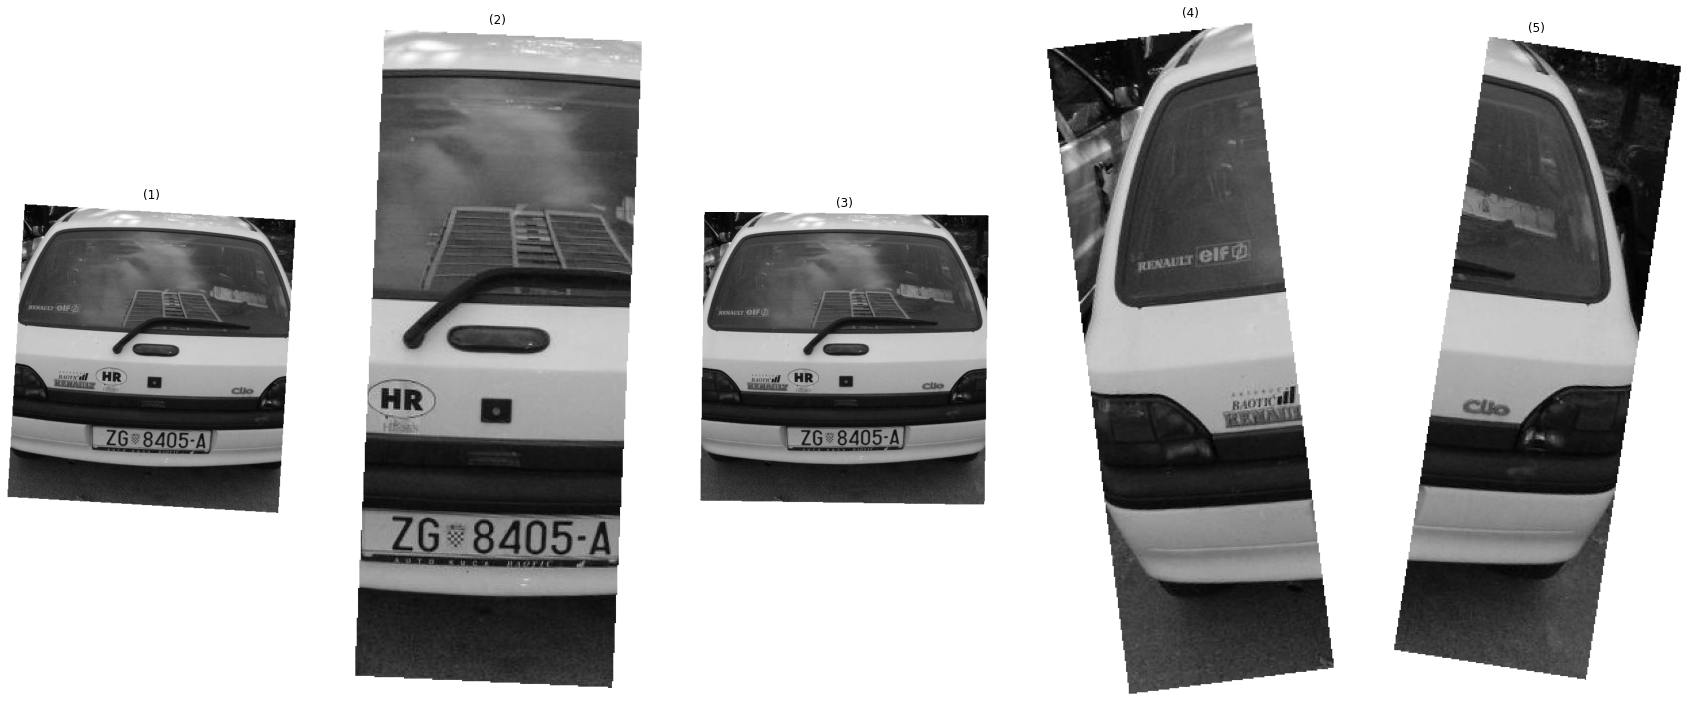

In [75]:
image = grayImage.astype('uint8')
gray = cv2.bilateralFilter(image, 11, 17, 17)

# Apply some preprocessing to the region of interest in order to get the edges
edged = sobel(gray)
th = threshold_otsu(np.abs(edged))
edged = edged > th
edged = edged.astype('uint8')

# Find contours based on Edges
contours  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Top 30 Contours
contours = contours[0] if len(contours) == 2 else contours[1]
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:50]

images = []

for contour in contours:
    rectangle = cv2.minAreaRect(contour)
    box = np.int0(cv2.boxPoints(rectangle))
    _, start, _, end = box
    width = np.abs(end[0] - start[0])
    height = np.abs(end[1] - start[1])
    if width > height and width > 150:
        xStart = min(start[0], end[0])
        xEnd = max(start[0], end[0])
        detectedLicensePlate = image[:, xStart : xEnd]

        sortedBasedOnX = box[np.argsort(box[:, 0])]

        pointsOfStartingVericalEdge = sortedBasedOnX[0 : 2]
        pointsOfEndingVericalEdge = sortedBasedOnX[2 :]
        print(pointsOfStartingVericalEdge, pointsOfEndingVericalEdge)

        lowerPointOfStart = pointsOfStartingVericalEdge[np.argsort(pointsOfStartingVericalEdge[:, 1])][0]
        lowerPointOfEnd = pointsOfEndingVericalEdge[np.argsort(pointsOfEndingVericalEdge[:, 1])][0]

        print(lowerPointOfStart, lowerPointOfEnd, "\n")
    
        angle = np.rad2deg(np.arctan2(lowerPointOfEnd[1] - lowerPointOfStart[1], lowerPointOfEnd[0] - lowerPointOfStart[0]))
        detectedLicensePlate = ndimage.rotate(detectedLicensePlate, angle, cval = 255)
        # print(detectedLicensePlate)
        images.append(detectedLicensePlate)
show_images(images)